<a href="https://colab.research.google.com/github/changsin/DL/blob/main/notebooks/image_similarity_using_clustering_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering on MNIST
Here is the result of clustering experiments on MNIST data. I wanted to see how robust clustering algorithm is for the data. I was hoping to see that most of the images would come to cluster into 10 groups. Unfortunately, this is not what I see. The images were too similar and the clustering algorithm could not reliably group them into neat categories whether you use cosine or Euclidean distance method.

The lesson? You need to know the dataset well and apply what works for the given dataset.

## Method Definitions

### Feature Map Clustering

In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from sklearn import preprocessing  # to normalise existing X


# #Calculate similar matrics
# def cosine_similarity(ratings):
#     sim = ratings.dot(ratings.T)
#     if not isinstance(sim,np.ndarray):
#         sim = sim.toarray()
#     norms = np.array([np.sqrt(np.diagonal(sim))])
#     return (sim/norms/norms.T)

def get_feature_maps(input):
    # i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    # x = tf.cast(i, tf.float32)
    # x = tf.keras.applications.mobilenet.preprocess_input(x)
    # #Convert to VGG input format
    # NB: This messes up the existing data so skipping it
    #   similarity measures do not seem to be affected by this.
    vgg_input = preprocess_input(input)
    

    #include_top=False == not getting VGG16 last 3 layers
    # model = VGG16(weights = "imagenet", include_top=False,
    #               input_shape = (input.shape[1], input.shape[2], 1))
    model = VGG16(weights = None, include_top=False,
                  input_shape = (input.shape[1], input.shape[2], 1))

    #Get features
    feature_maps = model.predict(vgg_input)
    # feature_maps = model.predict(input)

    return feature_maps, model

    # #Calculate similar metrics
    # features_compress = features.reshape(len(y_test), 7*7*512)
    # sim = cosine_similarity(features_compress)

# model_vgg16, feature_maps = get_feature_maps(X)

In [3]:
from sklearn.cluster import KMeans

def get_clusters(X_train_pca):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_train_pca_clusters = kmeans.fit(X_train_pca)

  return X_train_pca_clusters, kmeans

def get_feature_map_clusters(X, K):
  """
  param X: input data
  param K: number of clusters
  returns: X_clusters - clustered input data

  (side effect): plots the frequency histogram of clusters
  """
  X_fm, _ = get_feature_maps(X)
  # use cosine distance to find similarities
  X_fm_normalized = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

  return get_clusters(X_fm_normalized)

def to_cluster_idx(bins, labels):
  """
  param bins: range of K
  param labels: cluster labels
  returns: dictionary of cluster IDs
  """
  cluster_dict = dict()
  for cluster_id in bins:
    cluster_dict[cluster_id] = np.where(labels == cluster_id)[0]
  return cluster_dict

def to_clusters_dict(X, y, X_clusters, K):
  X_cluster_idx = to_cluster_idx(range(K), X_clusters.labels_)

  X_dict = {}
  y_dict = {}
  for id in range(K):
    ids = X_cluster_idx[id]
    X_dict[id] = X[ids]
    y_dict[id] = y[ids]

  return X_dict, y_dict

### PCA Clustering

In [4]:
from sklearn.decomposition import PCA

def to_pca(X_train, dimension=2):
  X_train_flatten = X_train.reshape(X_train.shape[0], -1)
  X_train_flatten.shape

  pca = PCA(dimension)

  X_train_pca = pca.fit_transform(X_train_flatten)

  # plot the scatter plot along the way
  plt.figure(1)
  plt.clf()

  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="Paired")
  plt.colorbar()

  return X_train_pca

### Plotting

In [5]:
import matplotlib.pyplot as plt

def plot_images(X, y, limit=10):
  fig = plt.figure(figsize=(20,40))

  # The number of images for plotting is limited to 50
  end_id = len(y) if len(y) < limit else limit

  for i in range(0, end_id):
    axis = fig.add_subplot(10, 5, i+1)
    plt.axis('off')
    image = X[i]

    plt.title("{}".format(y[i]))
    # plt.imshow(np.clip(image, 0, 1))
    plt.imshow(image)

def plot_images_idx(X, y, idx):
  plot_images(X[idx], y[idx])

In [6]:
def plot_cluster_histogram(X_clusters, K):
  histo_x, bins = np.histogram(X_clusters.labels_, bins=range(K + 1))
  plt.bar(bins[:-1], histo_x, align='center')

def plot_pca_clusters(X_train_pca, kmeans):
  # kmeans, X_train_pca_clusters = get_clusters(X_train_pca)

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
  y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired, aspect="auto", origin="lower")


  plt.plot(X_train_pca[:, 0], X_train_pca[:, 1], 'k.', markersize=2)
  # Plot the centroids as a white X
  centroids = kmeans.cluster_centers_
  plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
              color="w", zorder=10)
  plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
            "Centroids are marked with white cross")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

In [7]:
from scipy.spatial.distance import cdist

def find_duplicates(X_train_pca, threshold=0.001):
    # Calculate distances of all points
    distances = cdist(X_train_pca, X_train_pca, "euclidean")

    # Find duplicates (very similar images)
    sims = [np.array(np.where(distances[id] < threshold)).reshape(-1).tolist() \
            for id in range(distances.shape[0])]

    dupes = []

    to_remove = set()
    for d in sims:
        if len(d) > 1:
          dupes.append(d)
          for id in range(1, len(d)):
              to_remove.add(d[id])
    print("Found {} duplicates".format(len(to_remove)))
    return to_remove, dupes

## Executions

### Load MNIST data & rescale

Load MNIST data and rescale from 28x28 to 32x32 so that they can be processed by VGG16

In [8]:
from keras.datasets import mnist
from skimage.transform import rescale

import numpy as np

IMAGE_SIZE = 32

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train, X_test = X_train / 255.0, X_test / 255.0

# rescale to 32x32 to be processed by VGG16
# X_train_rescaled = np.array([rescale(x, 
#                                      IMAGE_SIZE/X_train.shape[1],
#                                      anti_aliasing=False) for x in X_train])

### Visualize the data a bit

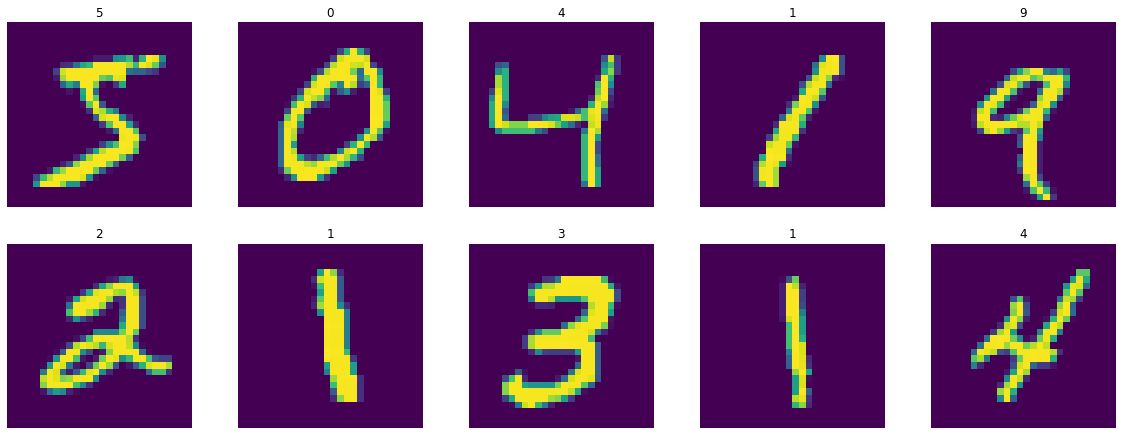

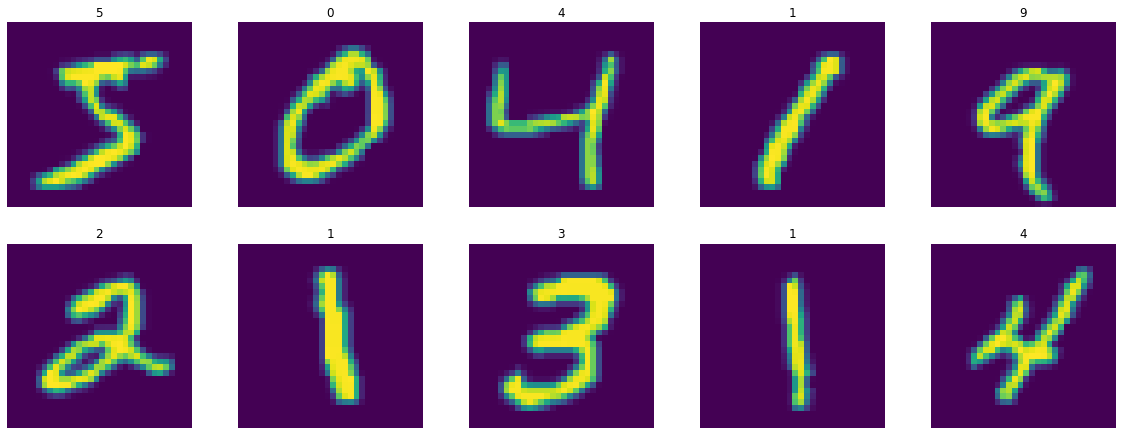

In [7]:
plot_images(X_train, y_train)
plot_images(X_train_rescaled, y_train)

# Use VGG16 feature maps to get clusters

In [15]:
K = 10
X_train_fm_clusters, kmeans_vgg16 = get_feature_map_clusters(X_train_rescaled, K)


In [28]:
# rescale to 32x32 to be processed by VGG16
X_train_rescaled = np.array([rescale(x, 
                                     IMAGE_SIZE/X_train.shape[1],
                                     anti_aliasing=False) for x in X_train])

In [ ]:
X_train_rescaled[0]

In [39]:
X_train_fmpca[0]

array([ 0.00044883, -0.00057077], dtype=float32)

In [40]:
X_train_fmpca[1]

array([ 0.00139932, -0.00055495], dtype=float32)

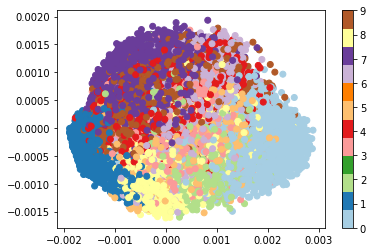

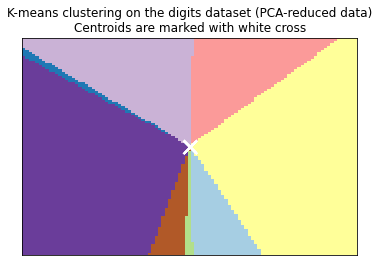

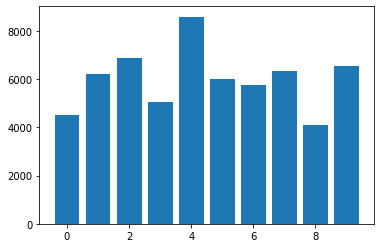

In [31]:
X_train_fm, _ = get_feature_maps(X_train_rescaled)

# X_train_fm_normalized = preprocessing.normalize(X_train_fm.reshape(len(X_train_fm), -1))
# kmeans = KMeans(n_clusters=K, random_state=0)
# X_train_pca_clusters = kmeans.fit(X_train_pca)


X_train_fmpca = to_pca(X_train_fm)
X_train_fmpca_clusters, kmeans_fmpca = get_clusters(X_train_fmpca)
plot_pca_clusters(X_train_fmpca, kmeans_fmpca)
plot_cluster_histogram(X_train_fmpca_clusters, K)

In [42]:
X_train_fmpca_clusters.labels_

array([2, 0, 6, ..., 4, 4, 9], dtype=int32)

In [32]:
X_train_fmpca_idx = to_cluster_idx(range(K), X_train_fmpca_clusters.labels_)

# X_train_pca_dict, y_train_pca_dict = to_clusters_dict(X_train_rescaled, y_train, skl_digits_pca_clusters, K)

# from collections import Counter

for key, idx in X_train_fmpca_idx.items():
  print(key, len(idx))

0 4493
1 6221
2 6881
3 5059
4 8586
5 6017
6 5762
7 6330
8 4114
9 6537


In [35]:
to_remove, dupes = find_duplicates(X_train_fmpca[X_train_fmpca_idx[0]])

Found 4492 duplicates


In [ ]:
X_train_pca_idx = to_cluster_idx(range(K), X_train_pca_clusters.labels_)

# X_train_pca_dict, y_train_pca_dict = to_clusters_dict(X_train_rescaled, y_train, skl_digits_pca_clusters, K)

# from collections import Counter

for key, idx in X_train_pca_idx.items():
  print(key, len(idx))

In [159]:
K = 10
X_train_fm_clusters, kmeans_vgg16 = get_feature_map_clusters(X_train_rescaled, K)
X_train_fm_dict, y_train_fm_dict = to_clusters_dict(X_train_rescaled, y_train, X_train_fm_clusters, K)

In [9]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

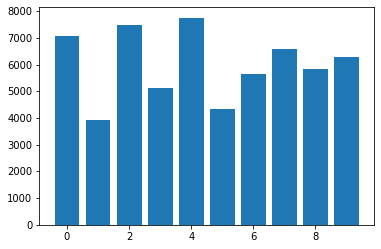

In [10]:
plot_cluster_histogram(X_train_fm_clusters, K)

# Use PCA to get clusters

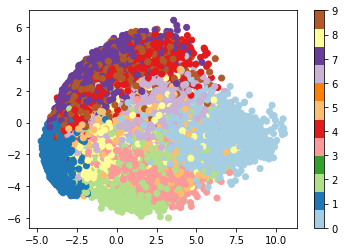

In [151]:
X_train_pca_3d = to_pca(X_train_rescaled, dimension=3)

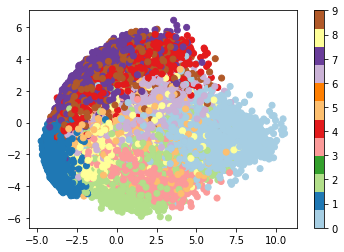

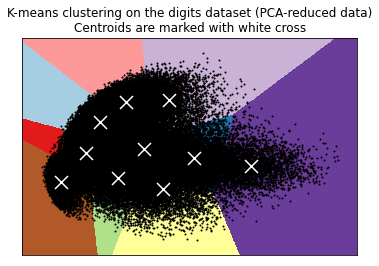

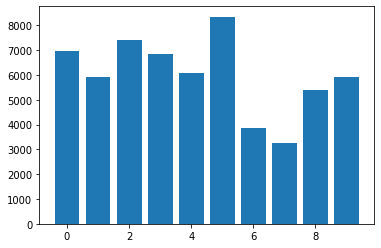

In [11]:
X_train_pca = to_pca(X_train_rescaled)
X_train_pca_clusters, kmeans = get_clusters(X_train_pca)
plot_pca_clusters(X_train_pca, kmeans)
plot_cluster_histogram(X_train_pca_clusters, K)

In [12]:
X_train_pca_idx = to_cluster_idx(range(K), X_train_pca_clusters.labels_)

# X_train_pca_dict, y_train_pca_dict = to_clusters_dict(X_train_rescaled, y_train, skl_digits_pca_clusters, K)

# from collections import Counter

for key, idx in X_train_pca_idx.items():
  print(key, len(idx))

0 6959
1 5902
2 7413
3 6837
4 6081
5 8353
6 3875
7 3272
8 5383
9 5925


In [153]:
X_train_pca_3d_idx = to_cluster_idx(range(K), X_train_pca_clusters_3d.labels_)


In [156]:
!pip install imagehash

     |████████████████████████████████| 296kB 7.6MB/s 


In [ ]:
X_train

In [74]:
from scipy.spatial.distance import cdist

cdistances = cdist(X_train_pca[X_train_pca_idx[0]], X_train_pca[X_train_pca_idx[0]])

# cluster0 = X_train_rescaled[X_train_pca_idx[0]]
# cluster0.shape

In [49]:
distances = cdist(np.array([X_train_pca[37], X_train_pca[731]]), np.array([X_train_pca[37], X_train_pca[731]]))

In [ ]:
distances = cdist(X_train_pca, X_train_pca)

In [134]:
to_remove, dupes = find_duplicates(X_train_pca[X_train_pca_idx[1]])

Found 8 duplicates


In [142]:
dupes_idx = [X_train_pca_idx[1][e] for e in [d for d in dupes]]
# dupes_idx

In [146]:
dupes_idx

[array([1184, 3392]),
 array([1184, 3392]),
 array([ 6239, 58894]),
 array([ 8043, 38335]),
 array([11922, 42160]),
 array([12119, 34584]),
 array([15723, 45354]),
 array([32858, 59976]),
 array([12119, 34584]),
 array([38195, 53127]),
 array([ 8043, 38335]),
 array([11922, 42160]),
 array([15723, 45354]),
 array([38195, 53127]),
 array([ 6239, 58894]),
 array([32858, 59976])]

In [ ]:
for bin in range(K):
  dupes = find_duplicates(X_train_pca[bin])

# Use InceptionV3 feature maps

In [ ]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import GlobalAveragePooling2D
from PIL import Image

import cv2

def convert_images(X):
  width = 299
  height = 299
  color = 3 #색수
  converted = []
  for x in X:
      # print(x.shape) #(28, 28, 1)
      image = Image.fromarray(x.astype('uint8'), 'L') #greyscale image
      image = image.convert('RGB')
      image = np.array(image.resize((width,height)))
      #print(image.shape) #(299, 299, 3)
      converted.append(image)
  return np.array(converted)

    # img_resize = cv2.resize(X, (299, 299))
    # img_temp = img_resize.astype(np.float32)
    # img_data = np.expand_dims(img_temp, axis=0)
    # return preprocess_input(img_data)

def get_inception_feature_map(input_data):
    model = InceptionV3(weights='imagenet', include_top=False)
    model_feature_map = GlobalAveragePooling2D()(model.output)
    model = Model(inputs=model.input, outputs=model_feature_map)
    f_map = model.predict(input_data)

    return f_map

# K = 10
# X_train_icp_clusters, kmeans_icp = get_feature_map_clusters(X_train_rescaled, K)
# X_train_fm_dict, y_train_fm_dict = to_clusters_dict(X_train_rescaled, y_train, X_train_fm_clusters, K)

# # X_train_pca_3d = to_pca(X_train_rescaled, dimension=3)


#   X_fm, _ = get_feature_maps(X)
#   # use cosine distance to find similarities
#   X_fm_normalized = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

#   return get_clusters(X_fm_normalized)


# (X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train_icp = convert_images(X_train)

In [ ]:
plot_images(X_train_icp, y_test)

In [71]:
X_train_icp.shape

(10000, 299, 299, 3)

In [10]:
icp_map = get_inception_feature_map(X_train_icp)
icp_map.shape

(10000, 2048)

In [73]:
icp_map[0].shape

(2048,)

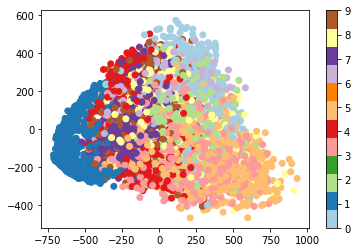

In [11]:
def to_pca(X_train, y_train, dimension=2):
  # X_train_flatten = X_train.reshape(X_train.shape[0], -1)
  # X_train_flatten.shape

  pca = PCA(dimension)

  X_train_pca = pca.fit_transform(X_train)

  # plot the scatter plot along the way
  plt.figure(1)
  plt.clf()

  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="Paired")
  plt.colorbar()

  return X_train_pca


X_train_icp_pca = to_pca(icp_map, y_test, dimension=2)

In [12]:
X_train_pca_icp.shape

(10000, 2)

In [15]:
K = 10

X_train_icp_clusters, kmeans_icp = get_clusters(X_train_pca_icp)
X_train_icp_idx = to_cluster_idx(range(K), X_train_icp_clusters.labels_)

In [ ]:
# plot_pca_clusters(X_train_pca_icp, kmeans_icp)
# plot_cluster_histogram(X_train_icp_clusters, K)

In [37]:
for bin in range(K):
  to_remove, dupes = find_duplicates(X_train_pca_icp[X_train_icp_idx[bin]], threshold=0.05)

Found 0 duplicates
Found 1 duplicates
Found 0 duplicates
Found 0 duplicates
Found 0 duplicates
Found 0 duplicates
Found 0 duplicates
Found 0 duplicates
Found 0 duplicates
Found 0 duplicates


In [29]:
to_remove, dupes = find_duplicates(X_train_pca_icp)

[[308, 839], [308, 839]]

In [32]:
X_train_icp_idx[0][839]

8124

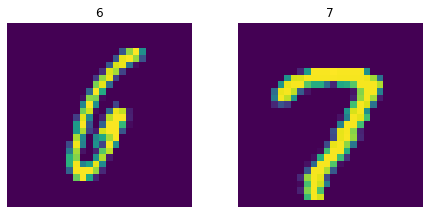

In [33]:
plot_images_idx(X_test, y_test, [3344, 8124])

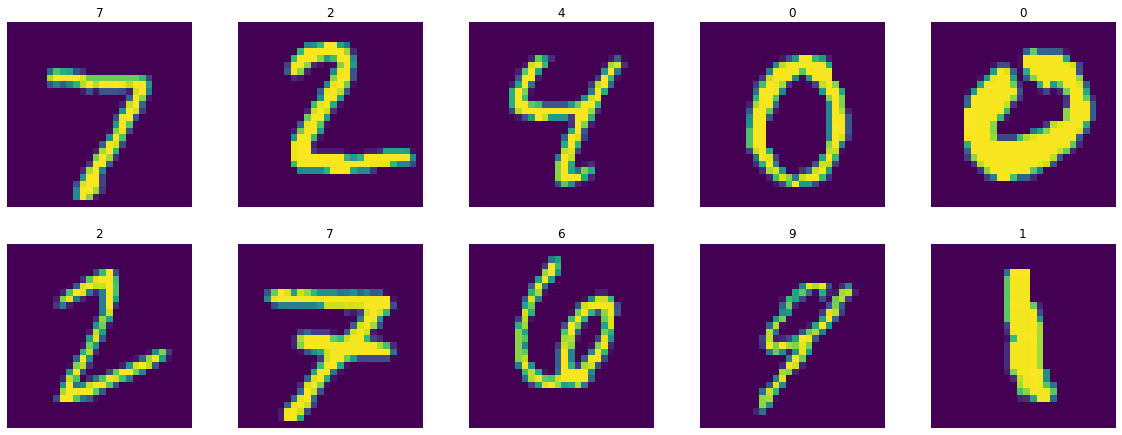

In [42]:
def plot_images_idx(X, y, idx):
  plot_images(X[idx], y[idx])

plot_images_idx(X_test, y_test, dupes[0])